# Importing Dependencies

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds


2025-07-22 12:06:36.818215: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753178796.892432 1043839 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753178796.911283 1043839 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1753178797.068488 1043839 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1753178797.068551 1043839 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1753178797.068553 1043839 computation_placer.cc:177] computation placer alr

# Loading and Visualising the data

Found 202599 files.


2025-07-22 12:07:22.621520: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


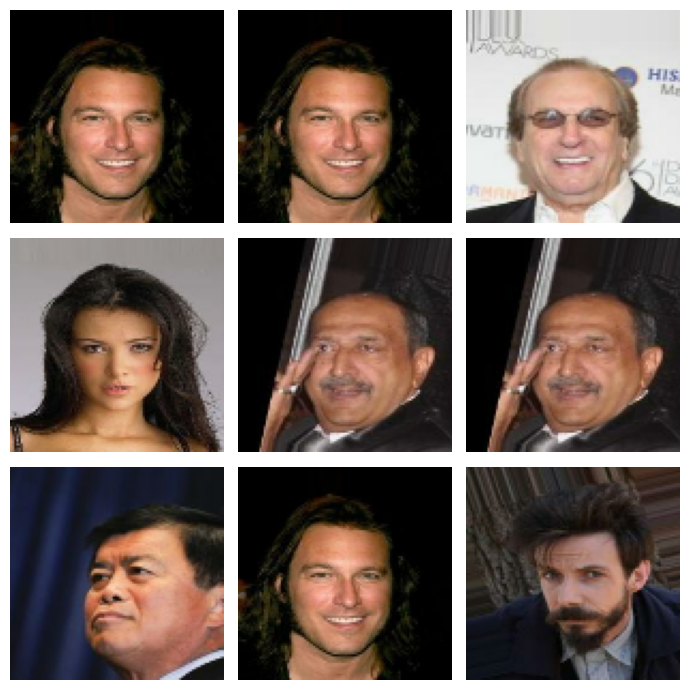

In [4]:
BATCH_SIZE = 8
IMG_HEIGHT = 100
IMG_WIDTH = 100

dataset = tf.keras.preprocessing.image_dataset_from_directory(
    directory="./celeba-dataset/img_align_celeba/img_align_celeba",
    seed=42,
    label_mode=None,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    shuffle=True
)

import random

total_batches = tf.data.experimental.cardinality(dataset=dataset).numpy()
rand_batch_index = random.randint(0, total_batches-1)

plt.figure(figsize=(7, 7))
for images in dataset.skip(rand_batch_index).take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    rand_img_index = random.randint(0, BATCH_SIZE-1)
    plt.imshow(images[rand_img_index].numpy().astype("uint8"))
    plt.axis(False)

plt.tight_layout()
plt.show()

# Data Preprocessing

In [6]:
def preprocess_images(dataset):
    dataset = dataset.map(lambda image: tf.cast(image, tf.float32) / 255.0)
    dataset = dataset.take(2**12)
    dataset = dataset.cache()
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    dataset = dataset.repeat()
    print(dataset.as_numpy_iterator().next()[0].shape)

preprocess_images(dataset)

(8, 100, 100, 3)


2025-07-22 12:08:53.521905: W tensorflow/core/kernels/data/cache_dataset_ops.cc:916] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


# Generator

In [7]:
def build_generator():
    generator = tf.keras.Sequential([

        tf.keras.layers.Dense(128*25*25, input_shape=[128], activation="leaky_relu"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Reshape((25,25,128)),

        tf.keras.layers.UpSampling2D(),
        tf.keras.layers.Conv2D(256, 4, padding="same", activation="leaky_relu"),
        tf.keras.layers.BatchNormalization(),

        tf.keras.layers.UpSampling2D(),
        tf.keras.layers.Conv2D(196, 4, padding="same", activation="leaky_relu"),
        tf.keras.layers.BatchNormalization(),
        
        tf.keras.layers.Conv2D(128, 4, padding="same", activation="leaky_relu"),
        tf.keras.layers.BatchNormalization(),

        tf.keras.layers.Conv2D(64, 4, padding="same", activation="leaky_relu"),
        tf.keras.layers.BatchNormalization(),

        tf.keras.layers.Conv2D(32, 4, padding="same", activation="leaky_relu"),
        tf.keras.layers.BatchNormalization(),        

        tf.keras.layers.Conv2D(16, 4, padding="same", activation="leaky_relu"),
        tf.keras.layers.BatchNormalization(),

        tf.keras.layers.Conv2D(3, 4, padding="same", activation="tanh")

    ])
    return generator

gen = build_generator()
gen.summary()

/home/abdulbari/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 80000)          │    10,320,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 80000)          │       320,000 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 25, 25, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 50, 50, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 50, 50, 256)    │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 50, 50, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 100, 100, 256)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 100, 100, 196)  │       803,012 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 100, 100, 196)  │           784 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 100, 100, 128)  │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 100, 100, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 100, 100, 64)   │       131,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 100, 100, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 100, 100, 32)   │        32,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 100, 100, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 100, 100, 16)   │         8,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 100, 100, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 100, 100, 3)    │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,544,775 (47.85 MB)

 Trainable params: 12,383,391 (47.24 MB)

 Non-trainable params: 161,384 (630.41 KB)

# Visualising Untrained Generated Images

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


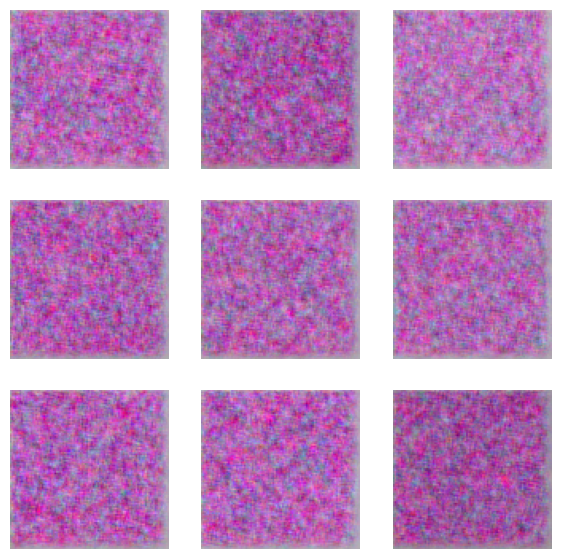

In [9]:
plt.figure(figsize=(7,7))
for i in range(9):
    ax = plt.subplot(3, 3, i+1)
    img = gen.predict(np.random.randn(1,128))
    img = (img - img.min()) / (img.max() - img.min())
    plt.imshow(np.squeeze(img))
    plt.axis(False)

# Discriminator

In [10]:
def build_discriminator():
    discriminator = tf.keras.Sequential([

        tf.keras.layers.Conv2D(64, 4, input_shape=[IMG_WIDTH,IMG_HEIGHT,3], padding="same", activation="leaky_relu"),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.BatchNormalization(),
        
        tf.keras.layers.Conv2D(128, 4, padding="same", activation="leaky_relu"),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.BatchNormalization(),

        tf.keras.layers.Conv2D(192, 4, padding="same", activation="leaky_relu"),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.BatchNormalization(),
        
        tf.keras.layers.Conv2D(192, 4, padding="same", activation="leaky_relu"),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.BatchNormalization(),
        
        tf.keras.layers.Conv2D(256, 4, padding="same", activation="leaky_relu"),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.BatchNormalization(),
        
        tf.keras.layers.Conv2D(256, 4, padding="same", activation="leaky_relu"),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.BatchNormalization(),

        tf.keras.layers.Conv2D(512, 4, padding="same", activation="leaky_relu"),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.BatchNormalization(),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(1, activation="tanh")
    ])
    return discriminator

disc = build_discriminator()
disc.summary()

/home/abdulbari/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_7 (Conv2D)               │ (None, 100, 100, 64)   │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100, 100, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 100, 100, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 100, 100, 128)  │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 100, 100, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 100, 100, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 100, 100, 192)  │       393,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 100, 100, 192)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 100, 100, 192)  │           768 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 100, 100, 192)  │       590,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 100, 100, 192)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 100, 100, 192)  │           768 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 100, 100, 256)  │       786,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 100, 100, 256)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 100, 100, 256)  │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 100, 100, 256)  │     1,048,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 100, 100, 256)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 100, 100, 256)  │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 100, 100, 512)  │     2,097,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 100, 100, 512)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 100, 100, 512)  │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 10,177,345 (38.82 MB)

 Trainable params: 10,174,145 (38.81 MB)

 Non-trainable params: 3,200 (12.50 KB)

# Custom Training Loop

In [ ]:
gen_opt = tf.keras.optimizers.Adam(1e-4, beta_1=0.5)
disc_opt = tf.keras.optimizers.Adam(1e-4, beta_1=0.5)

gen_loss = tf.keras.losses.BinaryCrossentropy()
disc_loss = tf.keras.losses.BinaryCrossentropy()

In [23]:
from tensorflow.keras.models import Model

class CelebGAN(Model):
    def __init__(self, generator, discriminator, *args, **kwargs):
        super().__init__(*args, **kwargs)

        self.generator = generator
        self.discriminator = discriminator
    
    def compile(self, gen_opt, disc_opt, gen_loss, disc_loss, *args, **kwargs):
        super().compile(*args, **kwargs)

        self.gen_opt = gen_opt
        self.disc_opt = disc_opt
        self.gen_loss = gen_loss
        self.disc_loss = disc_loss

    def train_step(self, data):
        self.step_counter = getattr(self, 'step_counter', 0)

        real_images = data
        generated_images = self.generator(tf.random.normal((BATCH_SIZE, 128)))

        with tf.GradientTape() as d_tape:
            generated_image_predictions = self.discriminator(generated_images, training=True)
            real_image_predictions = self.discriminator(real_images, training=True)
            disc_predictions = tf.concat([generated_image_predictions, real_image_predictions], axis=0)
            disc_labels = tf.concat([tf.zeros_like(generated_image_predictions), tf.ones_like(real_image_predictions)], axis=0)

            noise_generated_image_predictions = -0.15 * tf.random.stateless_uniform(
                tf.shape(generated_image_predictions), seed=[self.step_counter, 0]
            )
            noise_real_image_predictions = 0.15 * tf.random.stateless_uniform(
                tf.shape(real_image_predictions), seed=[self.step_counter, 1]
            )
            disc_labels += tf.concat([noise_generated_image_predictions, noise_real_image_predictions], axis=0)

            total_disc_loss = self.disc_loss(disc_labels, disc_predictions)

            disc_grad = d_tape.gradient(total_disc_loss, self.discriminator.trainable_variables)
            self.disc_opt.apply_gradients(zip(disc_grad, self.discriminator.trainable_variables))

        with tf.GradientTape() as g_tape:
            new_generated_images = self.generator(tf.random.normal((BATCH_SIZE, 128)), training=True)
            generator_predictions = self.discriminator(new_generated_images, training=False)

            total_gen_loss = self.gen_loss(tf.ones_like(generator_predictions), generator_predictions)

            gen_grad = g_tape.gradient(total_gen_loss, self.generator.trainable_variables)
            self.gen_opt.apply_gradients(zip(gen_grad, self.generator.trainable_variables))
        
        self.step_counter += 1

        return {"disc_loss": total_disc_loss, "gen_loss": total_gen_loss}


In [24]:
import os
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.callbacks import Callback
import tensorflow as tf

class ModelMonitor(Callback):
    def __init__(self, num_img=3, latent_dim=128, save_img_every=5, save_weights_every=50):
        self.num_img = num_img
        self.latent_dim = latent_dim
        self.save_img_every = save_img_every
        self.save_weights_every = save_weights_every
        self.save_dir = './'

        # Create subfolders for images and weights
        self.img_dir = os.path.join(self.save_dir, 'generated_images')
        self.weights_dir = os.path.join(self.save_dir, 'weights')

        os.makedirs(self.img_dir, exist_ok=True)
        os.makedirs(self.weights_dir, exist_ok=True)

    def on_epoch_end(self, epoch, logs=None):
        if epoch % self.save_img_every == 0:
            random_latent_vectors = tf.random.stateless_uniform(
                (self.num_img, self.latent_dim), seed=[epoch, 0]
            )
            generated_images = self.model.generator(random_latent_vectors)
            generated_images *= 255
            generated_images.numpy()
            for i in range(self.num_img):
                img = array_to_img(generated_images[i])
                img.save(os.path.join(self.img_dir, f"image_{epoch}_{i}.png"))

        if epoch % self.save_weights_every == 0:
            model_save_path = os.path.join(self.weights_dir, f"gan_weights_epoch_{epoch}.weights.h5")
            self.model.generator.save_weights(model_save_path)
            print(f"Model weights saved to {model_save_path}")


In [25]:
celeb = CelebGAN(gen, disc)
celeb.compile(gen_opt, disc_opt, gen_loss, disc_loss)

In [26]:
steps_per_epoch = 202599 // BATCH_SIZE
history = celeb.fit(dataset, epochs=300, steps_per_epoch=100 , callbacks=[ModelMonitor()])

Epoch 1/300
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 827ms/step - disc_loss: 8.0515 - gen_loss: 4.3528Model weights saved to ./weights/gan_weights_epoch_0.weights.h5
100/100 ━━━━━━━━━━━━━━━━━━━━ 100s 828ms/step - disc_loss: 8.0339 - gen_loss: 4.3097
Epoch 2/300
100/100 ━━━━━━━━━━━━━━━━━━━━ 82s 822ms/step - disc_loss: 4.9684 - gen_loss: 1.1921e-07
Epoch 3/300
100/100 ━━━━━━━━━━━━━━━━━━━━ 84s 838ms/step - disc_loss: 4.5659 - gen_loss: 1.1921e-07
Epoch 4/300
100/100 ━━━━━━━━━━━━━━━━━━━━ 83s 826ms/step - disc_loss: 4.6090 - gen_loss: 1.1921e-07
Epoch 5/300
100/100 ━━━━━━━━━━━━━━━━━━━━ 83s 828ms/step - disc_loss: 4.3250 - gen_loss: 1.1921e-07
Epoch 6/300
100/100 ━━━━━━━━━━━━━━━━━━━━ 82s 818ms/step - disc_loss: 4.2188 - gen_loss: 1.1921e-07
Epoch 7/300
100/100 ━━━━━━━━━━━━━━━━━━━━ 83s 831ms/step - disc_loss: 4.1057 - gen_loss: 1.1921e-07
Epoch 8/300
100/100 ━━━━━━━━━━━━━━━━━━━━ 82s 821ms/step - disc_loss: 4.0532 - gen_loss: 1.1921e-07
Epoch 9/300
100/100 ━━━━━━━━━━━━━━━━━━━━ 83s 831ms/step - disc_los

KeyboardInterrupt: 